#### Import Libraries

In [ ]:
%config Completer.use_jedi=False
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

#### Load the dataset

In [ ]:
# run in google colab to download csv file from drive
!pip install -q gdown
import gdown

file_id = "1qOec2D46l7K7ndHUUNhICLyX243yS0Dz"
url = f"https://drive.google.com/uc?id={file_id}"
output = "classification_dataset.csv"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qOec2D46l7K7ndHUUNhICLyX243yS0Dz
To: /content/classification_dataset.csv
100%|██████████| 96.7k/96.7k [00:00<00:00, 73.3MB/s]


'classification_dataset.csv'

In [ ]:
dataset = pd.read_csv('classification_dataset.csv')
dataset

,f1,f2,f3,f4,f5,label
0,1.286233,15.643743,-1.879915,-11.294839,15.245472,0
1,2.853398,0.129878,17.620669,3.945204,8.157459,1
2,3.285310,3.176560,12.610554,-6.063613,1.831887,0
3,2.019516,-1.967793,9.306435,-0.938714,-1.203038,0
4,-2.326527,3.453234,13.855478,-5.236421,1.547216,0
...,...,...,...,...,...,...
995,-2.248262,-4.619586,3.248760,9.114543,4.370790,1
996,7.882330,1.942559,13.304597,-2.682707,0.623444,0
997,14.421812,-10.688891,5.242771,-2.954794,11.689658,1
998,5.566459,-4.118762,3.670333,7.948329,10.940144,1


#### Define the loss function

In [ ]:
def loss_fn(y, yhat):
    # Small constant to prevent log(0), which is undefined (would result in -inf)
    epsilon = 1e-7

    # Clip predicted values to be within (epsilon, 1 - epsilon) to avoid log(0)
    yhat = tf.clip_by_value(yhat, epsilon, 1 - epsilon)

    # Compute binary cross-entropy loss:
    # For each prediction, calculate y*log(yhat) + (1 - y)*log(1 - yhat)
    # Take the negative and mean across all samples
    return -tf.reduce_mean(y * tf.math.log(yhat) + (1 - y) * tf.math.log(1 - yhat))

#### Define function to perform prediction

In [ ]:
def sigmoid(z):
    # Sigmoid activation function: maps input to (0, 1)
    return 1 / (1 + tf.exp(-z))

def relu(z):
    # ReLU activation function: replaces negative values with 0
    return tf.maximum(0.0, z)

def forward(W, B, x):
    # Forward pass through a simple 2-layer neural network

    # --- Hidden Layer ---
    # Linear transformation: z1 = x * W1 + b1
    z1 = tf.matmul(x, W[0]) + B[0]
    # Non-linear activation: a1 = ReLU(z1)
    a1 = relu(z1)

    # --- Output Layer ---
    # Linear transformation: z2 = a1 * W2 + b2
    z2 = tf.matmul(a1, W[1]) + B[1]
    # Non-linear activation: a2 = sigmoid(z2)
    # This gives predicted probabilities in [0, 1]
    a2 = sigmoid(z2)

    # Return final prediction
    return a2

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [ ]:
def train(W, B, x, y, alpha):
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        yhat = forward(W, B, x)       # Forward pass to get predictions
        loss = loss_fn(y, yhat)       # Compute loss between predictions and labels

    # Compute gradients of loss with respect to weights and biases
    grads = tape.gradient(loss, W + B)

    # Update weights and biases using gradient descent
    for i in range(len(W)):
        W[i].assign_sub(alpha * grads[i])                      # W = W - alpha * grad_W
        B[i].assign_sub(alpha * grads[i + len(W)])             # B = B - alpha * grad_B

    return loss.numpy()  # Return the scalar loss value as a float


def fit(model, train_ds, valid_ds, batch_size, alpha, max_epochs, patience):
    # Unpack model parameters (weights and biases)
    W1, W2, b1, b2 = model
    W = [W1, W2]
    B = [b1, b2]

    # Split training and validation datasets into features (X) and labels (y)
    X_train, y_train = train_ds
    X_val, y_val = valid_ds

    # Lists to store loss values over epochs for plotting
    train_loss_history = []
    val_loss_history = []

    # Initialize best validation loss for early stopping
    best_val_loss = float('inf')
    wait = 0  # Counter for patience
    best_weights = None  # Store best weights (for early stopping restoration)

    n_samples = X_train.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))  # Calculate number of mini-batches per epoch

    # Training loop over all epochs
    for epoch in range(max_epochs):
        # --- Shuffle training data at the start of each epoch ---
        # Prevents learning order bias and improves generalization
        indices = np.random.permutation(n_samples)
        X_train_shuffled = tf.gather(X_train, indices)
        y_train_shuffled = tf.gather(y_train, indices)

        epoch_train_loss = 0.0  # Accumulate total training loss for the epoch

        # --- Mini-batch training ---
        for batch in range(n_batches):
            # Define batch slice
            start = batch * batch_size
            end = min((batch + 1) * batch_size, n_samples)

            # Extract mini-batch data
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            # Perform one training step and get batch loss
            batch_loss = train(W, B, X_batch, y_batch, alpha)

            # Weighted accumulation of loss to get average at the end
            epoch_train_loss += batch_loss * (end - start)

        # Compute average training loss for the epoch
        epoch_train_loss /= n_samples
        train_loss_history.append(epoch_train_loss)

        # --- Validation loss computation ---
        yhat_val = forward(W, B, X_val)  # Predict on validation set
        epoch_val_loss = loss_fn(y_val, yhat_val).numpy()  # Compute validation loss
        val_loss_history.append(epoch_val_loss)

        # --- Early stopping check ---
        if epoch_val_loss < best_val_loss:
            # Improvement in validation loss — update best loss and save weights
            best_val_loss = epoch_val_loss
            wait = 0  # Reset wait counter
            best_weights = [tf.identity(w) for w in W] + [tf.identity(b) for b in B]
        else:
            # No improvement — increase wait counter
            wait += 1
            if wait >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                # Restore the best model weights before stopping
                for i in range(len(W)):
                    W[i].assign(best_weights[i])
                    B[i].assign(best_weights[i + len(W)])
                break  # Stop training

        # Print training and validation loss for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} - Train loss: {epoch_train_loss:.6f} - Val loss: {epoch_val_loss:.6f}")

    # Return loss history for visualization
    return train_loss_history, val_loss_history

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [ ]:
# Define model architecture
input_size = 5      # Number of features in the input
hidden_size = 32    # Number of neurons in the hidden layer
output_size = 1     # Output size (e.g., for binary classification)

# Initialize weight matrices with random values from a normal distribution
# stddev=0.1 helps keep initial values small for stable training
W1 = tf.Variable(tf.random.normal([input_size, hidden_size], stddev=0.1), name='W1')  # Shape: (5, 32)
W2 = tf.Variable(tf.random.normal([hidden_size, output_size], stddev=0.1), name='W2') # Shape: (32, 1)

# Initialize bias vectors with zeros
b1 = tf.Variable(tf.zeros([hidden_size]), name='b1')   # Shape: (32,)
b2 = tf.Variable(tf.zeros([output_size]), name='b2')   # Shape: (1,)

# Bundle all parameters into a model list for easier passing
model = [W1, W2, b1, b2]

#### Split the dataset
The ratio of training and test is 7:1:2.

In [ ]:
X = dataset[['f1', 'f2', 'f3', 'f4', 'f5']].values
y = dataset['label'].values.reshape(-1, 1)

# Split the dataset into training, validation, and test sets (7:1:2 ratio)
# First, we split the data into 80% training+validation and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training+validation set into 70% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(700, 5)
(700, 1)
(200, 5)
(200, 1)
(100, 5)
(100, 1)


#### Normalize the data

In [ ]:
from sklearn.preprocessing import StandardScaler
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Train the model

In [ ]:
# Train the model with early stopping
batch_size = 32
learning_rate = 0.02
max_epochs = 100
patience = 5  # Number of epochs to wait before stopping

train_loss, val_loss = fit(model, (X_train, y_train), (X_val, y_val),
                         batch_size, learning_rate, max_epochs, patience)

Epoch 1/100 - Train loss: 0.692596 - Val loss: 0.683228
Epoch 2/100 - Train loss: 0.676367 - Val loss: 0.667686
Epoch 3/100 - Train loss: 0.659741 - Val loss: 0.651053
Epoch 4/100 - Train loss: 0.641543 - Val loss: 0.632573
Epoch 5/100 - Train loss: 0.620827 - Val loss: 0.611366
Epoch 6/100 - Train loss: 0.597058 - Val loss: 0.586792
Epoch 7/100 - Train loss: 0.569682 - Val loss: 0.558685
Epoch 8/100 - Train loss: 0.538788 - Val loss: 0.527279
Epoch 9/100 - Train loss: 0.504896 - Val loss: 0.493331
Epoch 10/100 - Train loss: 0.468951 - Val loss: 0.457786
Epoch 11/100 - Train loss: 0.432135 - Val loss: 0.421851
Epoch 12/100 - Train loss: 0.395630 - Val loss: 0.386582
Epoch 13/100 - Train loss: 0.360541 - Val loss: 0.352966
Epoch 14/100 - Train loss: 0.327708 - Val loss: 0.321704
Epoch 15/100 - Train loss: 0.297660 - Val loss: 0.293300
Epoch 16/100 - Train loss: 0.270670 - Val loss: 0.267694
Epoch 17/100 - Train loss: 0.246788 - Val loss: 0.244893
Epoch 18/100 - Train loss: 0.225780 - Va

#### Display the training loss and validation loss against epoch graph

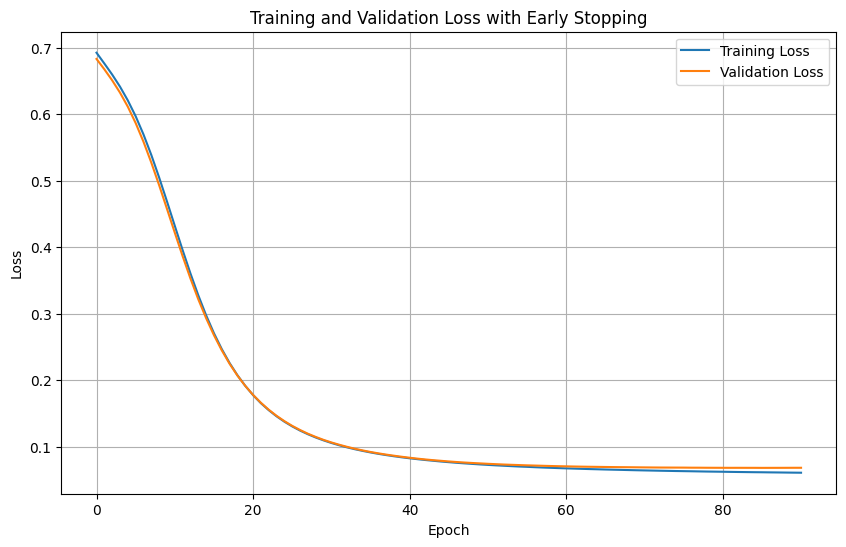

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.legend()
plt.grid(True)
plt.show()

#### Predict the test set

In [ ]:
# Evaluate on test set
W1, W2, b1, b2 = model
W = [W1, W2]
B = [b1, b2]

# Predict probabilities
y_prob = forward(W, B, X_test)
# Convert to binary predictions (0 or 1)
y_pred = (y_prob > 0.5).numpy().astype(int)

#### Display the confusion matrix and the classification report.

In [ ]:
# Display confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[97  3]
 [ 1 99]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       100
         1.0       0.97      0.99      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

